In [1]:
%load_ext autoreload
%autoreload 2

from cls2_data.data import Dataset
import evals2
from util import Logger

import editdistance
import numpy as np
import sexpdata
import torch
from torch import nn, optim
from torch.optim import lr_scheduler as opt_sched
from torch.autograd import Variable

SEED = 0
np_random = np.random.seed(SEED)
torch.manual_seed(SEED)

In [2]:
N_EMBED = 128
N_HIDDEN = 256
N_BATCH = 128

In [3]:
def unwrap(var):
    return var.data.cpu().numpy()

In [4]:
class Model(nn.Module):
    def __init__(self, dataset):
        super().__init__()
        self._conv_part = nn.Sequential(
            nn.Conv2d(3, 6, 5, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(6, 16, 5),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self._fc_part = nn.Sequential(
            nn.Linear(16*5*5, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU()
        )
        self._pred_part = nn.Sequential(
            nn.Linear(64, 64),
            nn.Tanh()
        )
        self._loss = nn.BCEWithLogitsLoss()
    
    def forward(self, batch):
        feats_in = batch.feats_in
        feats_out = batch.feats_out
        label_out = batch.label_out
        if next(self.parameters()).is_cuda:
            feats_in = feats_in.cuda()
            feats_out = feats_out.cuda()
            label_out = label_out.cuda()
            
        n_batch, n_ex, c, w, h = feats_in.shape
        conv_in = self._conv_part(feats_in.view(n_batch * n_ex, c, w, h))
        fc_in = self._fc_part(conv_in.view(n_batch * n_ex, 16*5*5))
        predictor = self._pred_part(fc_in.view(n_batch, n_ex, 64).sum(dim=1))
        
        conv_out = self._conv_part(feats_out)
        rep_out = self._fc_part(conv_out.view(n_batch, 16*5*5))
        
        score = (predictor * rep_out).sum(dim=1)
        labels = (score > 0).float()
        loss = self._loss(score, label_out)
        
        return loss, (labels == label_out).float().mean(), labels, predictor

In [5]:
def info(reps):
    buckets = np.zeros((64, 30))
    for rep in reps:
        for i in range(len(rep)):
            bucket = 15 + int(rep[i] * 30)
            bucket = max(bucket, 0)
            bucket = min(bucket, 29)
            buckets[i, bucket] += 1
    buckets += 1e-7
    probs = buckets / buckets.sum(axis=1, keepdims=True)
    logprobs = np.log(probs)
    entropies = -(probs * logprobs).sum(axis=1)
    return entropies.mean()

EPOCH = 'epoch'
TRN_LOSS = 'trn loss'
TRN_ACC = 'trn acc'
VAL_ACC = 'val acc'
CVAL_ACC = 'cval acc'
INFO_TX = 'I(T;X)'
ISOM = 'isom'
HOM = 'hom'
CHOM = 'c_hom'
LOG_KEYS = [EPOCH, TRN_LOSS, TRN_ACC, VAL_ACC, HOM,   ISOM,  INFO_TX]
LOG_FMTS = ['d',   '.3f',    '.3f',   '.3f',   '.3f', '.3f', '.3f']

class Composition(nn.Module):
    def forward(self, x, y):
        return x + y
comp_fn = Composition()
err_fn = evals2.CosDist()

def validate(dataset, model, logger, plot_log, epoch):
    val_batch = dataset.get_val_batch()
    _, val_acc, _, val_reps = model(val_batch)
    val_acc = val_acc.item()
    logger.update(VAL_ACC, val_acc)
    
    cval_batch = dataset.get_cval_batch()
    _, cval_acc, _, cval_reps = model(cval_batch)
    cval_acc = cval_acc.item()
    logger.update(CVAL_ACC, cval_acc)
    
    prim_batch = dataset.get_prim_batch()
    _, _, _, prim_reps = model(prim_batch)
    
    prim_rseq = [unwrap(prim_reps[i, ...]) for i in range(prim_reps.shape[0])]
    val_rseq = [unwrap(val_reps[i, ...]) for i in range(val_reps.shape[0])]
    cval_rseq = [unwrap(cval_reps[i, ...]) for i in range(cval_reps.shape[0])]
    
    comp = evals2.evaluate(
        prim_rseq + val_rseq, prim_batch.lf + val_batch.lf,
        comp_fn, err_fn, quiet=True)
    logger.update(HOM, np.mean(comp))
    
    #ccomp = evals2.evaluate(
    #    prim_rseq + cval_rseq, prim_batch.lf + cval_batch.lf,
    #    comp_fn, err_fn)[-len(cval_rseq):]
    #logger.update(CHOM, np.mean(ccomp))
    
    #logger.update(ISOM, eval_isom_tree(unwrap(val_reps), val_batch.lf))
    #info_tx = info(unwrap(nn.functional.tanh(val_reps)))
    info_tx = info(unwrap(val_reps))
    logger.update(INFO_TX, info_tx)
    
    plot_log.append((epoch, info_tx, np.mean(comp), val_acc))
    
    return val_acc

def train(dataset, model):
    #model.cuda()
    
    opt = optim.Adam(model.parameters(), lr=1e-3)
    sched = opt_sched.ReduceLROnPlateau(opt, factor=0.5, verbose=True, mode='max')
    logger = Logger(LOG_KEYS, LOG_FMTS, width=10)
    logger.begin()
    
    val_acc = validate(dataset, model, logger, [], -1)
    logger.print()
    
    plot_log = []
    for i in range(20):
        trn_loss = 0
        trn_acc = 0
        for j in range(100):
            batch = dataset.get_train_batch(N_BATCH)
            loss, acc, _, _ = model(batch)
            opt.zero_grad()
            loss.backward()
            opt.step()
            trn_loss += loss.item()
            trn_acc += acc.item()
            
            #if i == 0 and j % 10 == 0:
            #    validate(dataset, model, logger, [], -1)
            #    logger.print()
                
        trn_loss /= 100
        trn_acc /= 100
        
        logger.update(EPOCH, i)
        logger.update(TRN_LOSS, trn_loss)
        logger.update(TRN_ACC, trn_acc)
        val_acc = validate(dataset, model, logger, plot_log, i)
        sched.step(val_acc)
        logger.print()
    return plot_log

In [6]:
logs = []
dataset = Dataset()
for i in range(10):
    model = Model(dataset)
    log = train(dataset, model)
    logs.append(log)

|      epoch |   trn loss |    trn acc |    val acc |        hom |       isom |     I(T;X) |
|            |            |            |      0.496 |      0.015 |            |      0.757 |
|          0 |      0.663 |      0.600 |      0.668 |      0.108 |            |      1.955 |
|          1 |      0.630 |      0.655 |      0.688 |      0.150 |            |      2.453 |
|          2 |      0.613 |      0.678 |      0.704 |      0.159 |            |      2.743 |
|          3 |      0.598 |      0.683 |      0.720 |      0.181 |            |      2.802 |
|          4 |      0.583 |      0.694 |      0.706 |      0.181 |            |      2.848 |
|          5 |      0.581 |      0.695 |      0.700 |      0.197 |            |      2.866 |
|          6 |      0.569 |      0.709 |      0.742 |      0.197 |            |      2.869 |
|          7 |      0.555 |      0.720 |      0.748 |      0.198 |            |      2.898 |
|          8 |      0.548 |      0.723 |      0.724 |      0.182 |    

|            |            |            |      0.504 |      0.010 |            |      0.756 |
|          0 |      0.673 |      0.546 |      0.594 |      0.116 |            |      1.507 |
|          1 |      0.662 |      0.580 |      0.592 |      0.096 |            |      1.319 |
|          2 |      0.660 |      0.590 |      0.596 |      0.100 |            |      1.923 |
|          3 |      0.650 |      0.606 |      0.642 |      0.110 |            |      2.512 |
|          4 |      0.629 |      0.642 |      0.672 |      0.123 |            |      2.712 |
|          5 |      0.602 |      0.672 |      0.700 |      0.165 |            |      2.851 |
|          6 |      0.579 |      0.704 |      0.724 |      0.166 |            |      2.951 |
|          7 |      0.555 |      0.718 |      0.738 |      0.159 |            |      2.906 |
|          8 |      0.546 |      0.722 |      0.744 |      0.143 |            |      2.880 |
|          9 |      0.530 |      0.738 |      0.742 |      0.139 |    

|            |            |            |      0.502 |      0.023 |            |      1.024 |
|          0 |      0.656 |      0.597 |      0.688 |      0.141 |            |      2.274 |
|          1 |      0.631 |      0.656 |      0.698 |      0.138 |            |      2.462 |
|          2 |      0.602 |      0.685 |      0.718 |      0.148 |            |      2.755 |
|          3 |      0.583 |      0.697 |      0.718 |      0.156 |            |      2.752 |
|          4 |      0.580 |      0.703 |      0.720 |      0.158 |            |      2.787 |
|          5 |      0.574 |      0.704 |      0.720 |      0.158 |            |      2.776 |
|          6 |      0.563 |      0.710 |      0.728 |      0.154 |            |      2.795 |
|          7 |      0.557 |      0.718 |      0.742 |      0.167 |            |      2.811 |
|          8 |      0.538 |      0.733 |      0.738 |      0.143 |            |      2.800 |
|          9 |      0.522 |      0.744 |      0.732 |      0.144 |    

(0.707063088342884, 1.7203824835743277e-17)


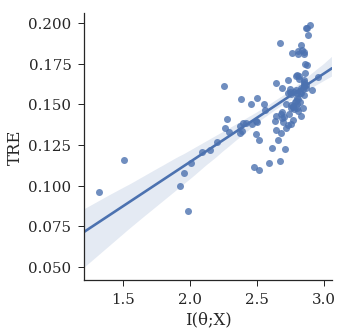

In [12]:
from matplotlib import pyplot as plt
from pandas import DataFrame
import seaborn as sns
import scipy

sns.set(font_scale=1.5)
sns.set_style("ticks", {'font.family': 'serif'})
plt.tight_layout()
#cmap = sns.color_palette("coolwarm", 10)

best_stops = [np.argmax(l, axis=0)[3] for l in logs]

my_logs = logs
my_logs = [my_logs[i][:best_stops[i]] for i in range(len(my_logs))]
log = sum(my_logs, [])
data = DataFrame(np.asarray(log), columns=['epoch', 'I(θ;X)', 'TRE', 'val'])
sns.lmplot(x='I(θ;X)', y='TRE', data=data)
print(scipy.stats.pearsonr(data['I(θ;X)'], data['TRE']))
plt.savefig('meta2_scatter_all.pdf', format='pdf')
plt.show()

(0.7138623817683064, 1.2272481355539673e-08)


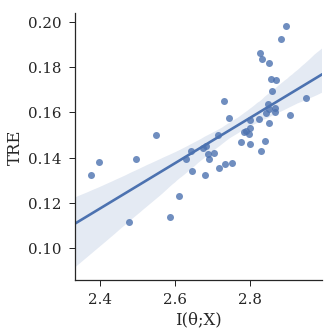

In [21]:
#my_logs = [l[10:] for l in my_logs]
#my_logs = [l[10:-2] for l in logs]
info_maxes = [np.argmax(l, axis=0)[1] for l in logs]
my_logs = logs
my_logs = [my_logs[i][info_maxes[i]:best_stops[i]] for i in range(len(my_logs))]
#my_logs = [my_logs[i][0:info_maxes[i]] for i in range(len(my_logs))]
log = sum(my_logs, [])
data = DataFrame(np.asarray(log), columns=['epoch', 'I(θ;X)', 'TRE', 'val'])
sns.lmplot(x='I(θ;X)', y='TRE', data=data)
print(scipy.stats.pearsonr(data['I(θ;X)'], data['TRE']))
plt.savefig('meta2_scatter_last.pdf', format='pdf')
plt.show()

(0.7218689328490042, 0.003556924610567421)


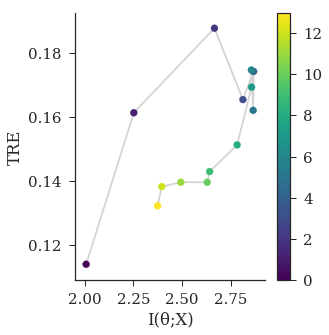

In [33]:
use_log = 6
log = logs[use_log][:best_stops[use_log]]
data = DataFrame(np.asarray(log), columns=['epoch', 'I(θ;X)', 'TRE', 'val'])
g = sns.lmplot(x='I(θ;X)', y='TRE', data=data, fit_reg=False, scatter=False)
plt.plot(data['I(θ;X)'], data['TRE'], color='lightgray', zorder=-1)
plt.scatter(data['I(θ;X)'], data['TRE'], c=data['epoch'].astype(int), cmap='viridis')
print(scipy.stats.pearsonr(data['I(θ;X)'], data['TRE']))
plt.colorbar(ticks=range(0, 20, 2))
plt.savefig('meta2_scatter_1.pdf', format='pdf')
plt.show()